In [1]:
import random
import re
import ipywidgets as widgets
from IPython.display import display

In [2]:
from dicesapi import DicesAPI
api = DicesAPI(dices_api='http://localhost:8000/api')
# this is just to provide progress bars in Jupyter
from dicesapi.jupyter import NotebookPBar
api._ProgressClass = NotebookPBar

In [3]:
from cltk.corpus.utils.importer import CorpusImporter
corpora = [
    '{}_models_cltk',
    '{}_text_perseus',
    '{}_treebank_perseus',
    '{}_lexica_perseus',
]

print('Importing corpora:')

for lang in ['latin', 'greek']:
    downloader = CorpusImporter(lang)
    for corpus in corpora:
        print(" - " + corpus.format(lang))
        downloader.import_corpus(corpus.format(lang))

from cltk.tokenize.word import WordTokenizer
tokenizer = {
    'greek': WordTokenizer('greek'),
    'latin': WordTokenizer('latin'),
}

Importing corpora:
 - latin_models_cltk
 - latin_text_perseus
 - latin_treebank_perseus
 - latin_lexica_perseus
 - greek_models_cltk
 - greek_text_perseus
 - greek_treebank_perseus
 - greek_lexica_perseus


# Download some speeches

In [4]:
speeches = api.getSpeeches(work_title='Iliad', progress=True) + \
            api.getSpeeches(work_title='Odyssey', progress=True)
speeches.sort()

# Download the text of the speeches

In [15]:
# create a progress bar
pbar = widgets.IntProgress(
    value = 0,
    min = 0,
    max = len(speeches),
    bar_style='info',
    orientation='horizontal'
)
pbar_label = widgets.Label(value = f'Downloading {pbar.value}/{len(speeches)}')
display(widgets.HBox([pbar, pbar_label]))

# download text, add to speech object as new attribute
for s in speeches:
    cts_passage = s.getCTS()
    s.text = cts_passage.text
    pbar.value += 1
    pbar_label.value = f'Downloading {pbar.value}/{len(speeches)}'

# Lemmatizing

In [6]:
from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer
from cltk.lemmatize.greek.backoff import BackoffGreekLemmatizer
lemmatizer = {
    'greek': BackoffGreekLemmatizer(),
    'latin': BackoffLatinLemmatizer(),    
}

# regular expressions to tidy up perseus texts for ctlk
replacements = {
    'greek': [
        (r'·', ','),           # FIXME: raised dot? 
        (chr(700), chr(8217)), # two different apostrophes that look alike
    ],
    'latin': [
        
    ],
}

# compile the regexes
for lang in ['greek', 'latin']:
    replacements[lang] = [(re.compile(pat), repl) for pat, repl in replacements[lang]]
    

# generic tokenize-lemmatize function
def lemmatize(text, lang):
    '''return a set of (token,lemmata) pairs for a string'''
    
    for pat, repl in replacements[lang]:
        text = pat.sub(repl, text)
    
    tokens = tokenizer[lang].tokenize(text)
    lemmata = lemmatizer[lang].lemmatize(tokens)
    
    return lemmata

In [42]:
# create a progress bar
pbar = widgets.IntProgress(
    value = 0,
    min = 0,
    max = len(speeches),
    bar_style='info',
    orientation='horizontal'
)
pbar_label = widgets.Label(value = f'Lemmatizing {pbar.value}/{len(passages)}')
display(widgets.HBox([pbar, pbar_label]))

# download text of speeches
for s in speeches:
    lang = s.work.lang
    toks = []
    lems = []
    for t, l in lemmatize(s.text.lower(), lang):
        toks.append(t)
        lems.append(l)
    s.tokens = toks
    s.lemmata = lems
        
    pbar.value += 1
    pbar_label.value = f'Lemmatizing {pbar.value}/{len(passages)}'

# Compare two speeches to see whether they share lemmata

In [39]:
def lem_comp(speech_a, speech_b, inc_punc=False):
    shared = set([lem for lem in speech_a.lemmata if lem in speech_b.lemmata])
    
    if not inc_punc:
        if 'punc' in shared:
            shared = set([lem for lem in shared if lem != 'punc'])
    
    return shared

In [43]:
shared_lems_reply = []
nshared_reply = []
debug = True

for i in range(1, len(speeches)):
    j = i - 1
    
    if speeches[i].part > 1:
        shared = lem_comp(speeches[i], speeches[j])
        
        shared_lems_reply.append(shared)
        nshared_reply.append(len(shared)/len(speeches[j].lemmata))
        
        if debug:
            print('\t'.join([
                str(speeches[i]),
                str(speeches[j]),
                str(len(speeches[i].lemmata)),
                str(len(speeches[j].lemmata)),
                str(len(shared)),
                str(shared),
            ]))

<Speech: Homer Iliad 1.26-1.32>	<Speech: Homer Iliad 1.17-1.21>	61	40	7	{'σύ', 'καί', 'ὁ', 'δέ', 'λύω', 'θεός', 'ἐγώ'}
<Speech: Homer Iliad 1.74-1.83>	<Speech: Homer Iliad 1.59-1.67>	87	78	16	{'οἴομαι', 'ἀπόλλων', 'καί', 'σύ', 'χόω', 'τελέω', 'εἰμί', 'ὁ', 'γε', 'ἀλλά', 'ὅς', 'εἰ', 'ἀχαιός', 'γάρ', 'ἐγώ', 'τε'}
<Speech: Homer Iliad 1.85-1.91>	<Speech: Homer Iliad 1.74-1.83>	55	87	13	{'ἀπόλλων', 'καί', 'σύ', 'διῒ', 'φίλος', 'εἰμί', 'ὁ', 'ὅς', 'τε', 'ἀχαιός', 'γάρ', 'ἐγώ', 'χείρ'}
<Speech: Homer Iliad 1.93-1.100>	<Speech: Homer Iliad 1.85-1.91>	66	55	9	{'δαναός', 'καί', 'σύ', 'ὁ', 'οὐδός', 'ὅς', 'οὐ', 'ἀγαμέμνων', 'φίλος'}
<Speech: Homer Iliad 1.106-1.120>	<Speech: Homer Iliad 1.93-1.100>	133	66	13	{'δίδωμι', 'ἄποινα', 'καί', 'δαναός', 'σύ', 'ἄρα', 'ὁ', 'ἑκηβόλος', 'ἀλλά', 'γε', 'κόρη', 'οὐ', 'φίλος'}
<Speech: Homer Iliad 1.122-1.129>	<Speech: Homer Iliad 1.106-1.120>	63	133	17	{'γέρας', 'ἀτάρ', 'λαός', 'δίδωμι', 'ὅδε', 'σύ', 'πολύς', 'ὁ', 'ἀλλά', 'πᾶς', 'δέ', 'νῦν', 'εἰ', 'γάρ', 'τίς', 

In [44]:
shared_lems_no_reply = []
nshared_no_reply = []
debug=False

for i in range(len(speeches)):
    j = random.randint(0, len(speeches)-1)

    if speeches[i].part > 1:
        shared = lem_comp(speeches[i], speeches[j])
        
        shared_lems_no_reply.append(shared)
        nshared_no_reply.append(len(shared)/len(speeches[j].lemmata))
        
        if debug:
            print('\t'.join([
                str(speeches[i-1]),
                str(speeches[i]),
                str(len(passages[i-1])),
                str(len(passages[i])),
                str(len(shared)),
                str(shared)
            ]))

In [12]:
from matplotlib import pyplot
%matplotlib inline

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd6804ba0b8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd6804ba6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd6804ba080>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd6804bac50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd6804baf28>,
 'means': []}

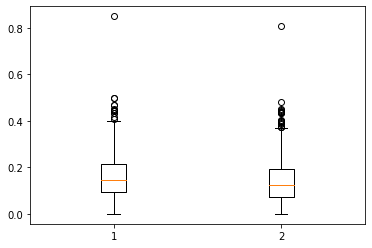

In [45]:
pyplot.boxplot([nshared_reply, nshared_no_reply])

In [41]:
for i in range(5):
    print(f'{i}\t{speeches[i].lemmata}\n\t{speeches[i+1].lemmata}\n{lem_comp(speeches[i], speeches[i+1])}\n')

0	['διογενής', 'λαερτιάδης', 'punc', 'πολυμήχανος', 'ὀδυσσεύς', 'punc', 'ἴσχω', 'punc', 'παύω', 'δέ', 'νεῖκος', 'ὁμοιΐου', 'πόλεμος', 'punc', 'μή', 'πως', 'σύ', 'κρονίδης', 'χολόω', 'εὐρύοπα', 'ζεύς', 'punc']
	['διογενής', 'λαερτιάδης', 'punc', 'πολυμήχανος', 'ὀδυσσεύς', 'punc', 'ἴσχω', 'punc', 'παύω', 'δέ', 'νεῖκος', 'ὁμοιΐου', 'πόλεμος', 'punc', 'μή', 'πως', 'σύ', 'κρονίδης', 'χολόω', 'εὐρύοπα', 'ζεύς', 'punc']
{'νεῖκος', 'διογενής', 'παύω', 'ζεύς', 'σύ', 'λαερτιάδης', 'ἴσχω', 'πόλεμος', 'μή', 'ὁμοιΐου', 'εὐρύοπα', 'δέ', 'πολυμήχανος', 'ὀδυσσεύς', 'κρονίδης', 'χολόω', 'πως'}

1	['διογενής', 'λαερτιάδης', 'punc', 'πολυμήχανος', 'ὀδυσσεύς', 'punc', 'ἴσχω', 'punc', 'παύω', 'δέ', 'νεῖκος', 'ὁμοιΐου', 'πόλεμος', 'punc', 'μή', 'πως', 'σύ', 'κρονίδης', 'χολόω', 'εὐρύοπα', 'ζεύς', 'punc']
	['διογενής', 'λαερτιάδης', 'punc', 'πολυμήχανος', 'ὀδυσσεύς', 'punc', 'ἴσχω', 'punc', 'παύω', 'δέ', 'νεῖκος', 'ὁμοιΐου', 'πόλεμος', 'punc', 'μή', 'πως', 'σύ', 'κρονίδης', 'χολόω', 'εὐρύοπα', 'ζεύς', 'punc'